In [1]:
%%html

<!-- Align the markdown tables to the left-->

<style>
table {
    margin-left: 0 !important;
    margin-right: auto;
}
</style>

# Overview

We will cover the following topics in this chapter:

* Airline passengers time series dataset:
    * Description and downloading of the dataset
    * Visualizing the dataset


* Preprocessing the dataset for RNN in `TensorFlow`
* RNN in `TensorFlow` for time series data:
    * SimpleRNN in TensorFlow
    * LSTM in TensorFlow
    * GRU in TensorFlow


* Preprocessing the dataset for RNN in `Keras`
* RNN in `Keras` for time series data:
    * SimpleRNN in Keras
    * LSTM in Keras
    * GRU in Keras

# RNN in TensorFlow - TimeSeries Data <a class="tocSkip">

In [2]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import sklearn
import sklearn.preprocessing
print("sklearn:{}".format(sklearn.__version__))

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {
        'font.size': 20,
        'figure.figsize': [15,10] 
    }
)
print("Matplotlib:{}".format(matplotlib.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

NumPy:1.18.5
Pandas:1.2.4
sklearn:0.24.2
Matplotlib:3.3.4
TensorFlow:1.15.5


In [3]:
DATASETSLIB_HOME = '../datasetslib'

import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)

%reload_ext autoreload
%autoreload 2

import datasetslib
from datasetslib import util as dsu
datasetslib.datasets_root = os.path.abspath('../datasets')

# Read and pre-process the dataset

In [4]:
filepath = os.path.join(
    datasetslib.datasets_root,
    'ts-data',
    'international-airline-passengers.csv'  # Note: NOT `-cleaned` version, don't have that one.
) 
dataframe = pd.read_csv(
    filepath,
    usecols=[1],
    header=0
).dropna()  # Needed.

dataset = dataframe.values
dataset = dataset.astype(np.float32)

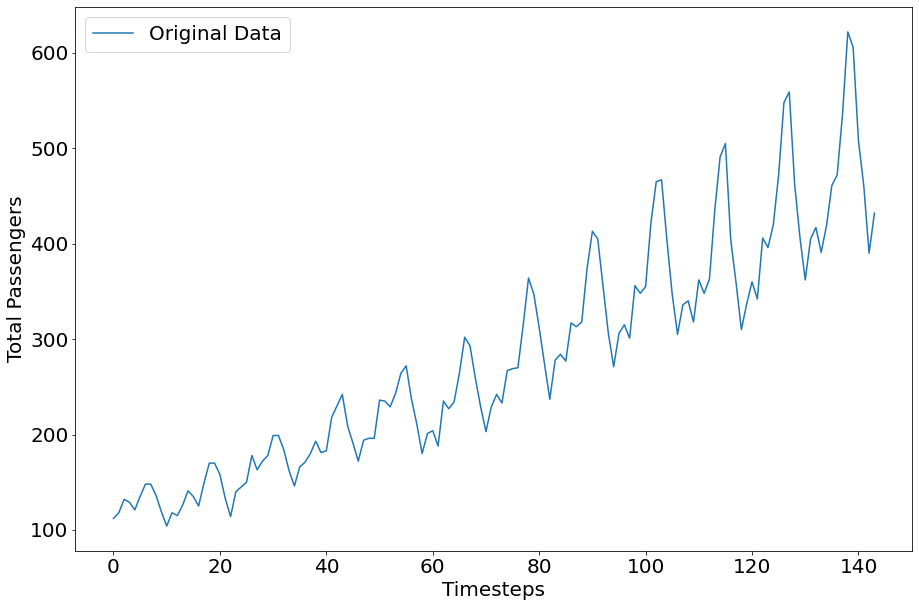

In [5]:
plt.plot(dataset, label='Original Data')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

In [6]:
# Normalize the dataset
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

In [7]:
print(normalized_dataset.shape)
print(normalized_dataset[0:5])

(144, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [65]:
# Split into train and test sets:
train, test = dsu.train_test_split(normalized_dataset, train_size=0.67)  # Using a splitter from their helper datasetlib, as we're splitting over time.

# Convert into supervised learning set of input data and label
n_x = 1
n_y = 1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=n_y)

In [9]:
print("X_train.shape:", X_train.shape)
print(X_train[0:5], "\n...")

print("Y_train.shape:", Y_train.shape)
print(Y_train[0:5], "\n...")

print(
    "\n💁 So we see that the data has been preprocessed as \"supervised problem\" of window size 1:\n"
    "X = [[t_0, t_1, t_2,...]]\n"
    "y = [[t_1, t_2, t_3,...]]\n"
)

X_train.shape: (95, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]] 
...
Y_train.shape: (95, 1)
[[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]] 
...

💁 So we see that the data has been preprocessed as "supervised problem" of window size 1:
X = [[t_0, t_1, t_2,...]]
y = [[t_1, t_2, t_3,...]]



### Note on "supervised set" in time series context

We convert the `train` and `test` datasets into **supervised machine learning sets**. 
Let's try to understand the meaning of a supervised learning set. 
Let's say that we have a sequence of data: `1,2,3,4,5`. 
We want to *learn the probability distribution that **generated** the dataset*. 
In order to do this, we can assume that the value at time step $t$ is a result of values from time steps $t-1$ to $t-k$, where $k$ is the window size. 

To simplify things, let's say the window size is 1.
Thus, the value at time step $t$, known as the target, is the result of value at time step $t-1$, known as intput feature(s). 

Let's repeat this for all time steps, and we get the following table (*window size 1*):

| Input value or feature | Output value or target |
| ---------------------- | ---------------------- |
| 1 | 2 |
| 2 | 3 |
| 3 | 4 |
| 4 | 5 |
| 5 | 5 |

**In any case, all of the above applies to *univariate* case, but there can also similarly be the *multivariate* case, which adds another dimension to this.**

# TensorFlow SimpleRNN for TimeSeries Data

In [10]:
state_size = 4  # NOTE: The state_size represents the number of weight vectors of an RNN cell.
n_epochs = 100

n_timesteps = n_x   # number of time steps
n_x_vars = 1        # number of x variables
n_y_vars = 1        # number of y variables

learning_rate = 0.1

print("-" * 20)
print("state_size:", state_size)
print("-" * 20)
print("n_timesteps:", n_timesteps)
print("n_x_vars:", n_x_vars)
print("n_y_vars:", n_y_vars)
print("-" * 20)

--------------------
state_size: 4
--------------------
n_timesteps: 1
n_x_vars: 1
n_y_vars: 1
--------------------


In [11]:
tf.reset_default_graph()

In [12]:
# Define data placeholders:
X_placeholder = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='X_placeholder')  # (batch_size, n_steps, n_input)
Y_placeholder = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='Y_placeholder')  # (batch_size, n_steps, n_output)

In [13]:
# Make a list of tensors of length n_x:
# See the `rnn_inputs` argument to `static_rnn()` below - wants LIST OF TENSORS of shape (batch_size, number_of_inputs)
print("X_placeholder.shape:", X_placeholder.shape)
rnn_inputs = tf.unstack(X_placeholder, axis=1)
print("rnn_inputs:", rnn_inputs)

X_placeholder.shape: (?, 1, 1)
rnn_inputs: [<tf.Tensor 'unstack:0' shape=(?, 1) dtype=float32>]


### Defining the cell.

Create a simple RNN cell using `tf.nn.rnn_cell.BasicRNNCell`.

TensorFlow provides the `static_rnn` and `dynamic_rnn` *convenience methods* (among others) to create a static and dynamic RNN respectively.
* Static RNN creates the cells, i.e. **unrolls the loop**, at the *compile* time. 
* Dynamic RNN creates the cells, namely **unrolls the loop**, at the *runtime*.

In [14]:
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)

rnn_outputs, final_state = tf.nn.static_rnn(
    cell,              # The basic RNN cell object that we defined earlier. It could be another kind of cell, as we will see further in the chapter.
    rnn_inputs,        # The **list of Tensors** of shape (batch_size, number_of_inputs)
    dtype=tf.float32   # The data type of initial state and expected outputs.
)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
print("len(rnn_outputs):", len(rnn_outputs))
print("rnn_outputs", rnn_outputs)
print("final_state", final_state)

len(rnn_outputs): 1
rnn_outputs [<tf.Tensor 'rnn/basic_rnn_cell/Tanh:0' shape=(?, 4) dtype=float32>]
final_state Tensor("rnn/basic_rnn_cell/Tanh:0", shape=(?, 4), dtype=float32)


In [16]:
# Here, use the convenience function `get_variable()` to define the variables for W and b.
W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

print("W", W)
print("b", b)

W <tf.Variable 'W:0' shape=(4, 1) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(1,) dtype=float32_ref>


In [17]:
predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
print(predictions)

[<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>]


In [18]:
print("Y_placeholder.shape:", Y_placeholder.shape)
y_as_list = tf.unstack(Y_placeholder, num=n_timesteps, axis=1)
print("y_as_list:", y_as_list)

Y_placeholder.shape: (?, 1, 1)
y_as_list: [<tf.Tensor 'unstack_1:0' shape=(?, 1) dtype=float32>]


In [19]:
# Define the loss function as mean squared error between the predicted and actual labels:
mse = tf.losses.mean_squared_error
losses = [
    mse(labels=label, predictions=prediction) 
    for prediction, label 
    in zip(predictions, y_as_list)
]
total_loss = tf.reduce_mean(losses)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    
    # --- Training ---
    epoch_loss = 0.0
    for epoch in range(n_epochs):
        feed_dict={
            # Note the reshaping into appropriate shape:
            X_placeholder: X_train.reshape(-1, n_timesteps, n_x_vars), 
            Y_placeholder: Y_train.reshape(-1, n_timesteps, n_x_vars)
        }
        epoch_loss, y_train_pred, _ = tfs.run(
            [total_loss, predictions, optimizer],  # <-- Note what we're computing here. 
            feed_dict=feed_dict
       )
    print("train mse = {}".format(epoch_loss))
    
    # --- Evaluation ---
    feed_dict={
        X_placeholder: X_test.reshape(-1, n_timesteps, n_x_vars), 
        Y_placeholder: Y_test.reshape(-1, n_timesteps, n_y_vars)
    }
    test_loss, y_test_pred = tfs.run(
        [total_loss, predictions], 
        feed_dict=feed_dict
    )
    
    print('test mse = {}'.format(test_loss))
    print('test rmse = {}'.format(math.sqrt(test_loss)))

train mse = 0.002078630728647113
test mse = 0.01255972869694233
test rmse = 0.11207019539976866


In [22]:
# These are returned as lists with one array item in them, so take them out of that list.
y_train_pred = y_train_pred[0]
y_test_pred = y_test_pred[0]

In [23]:
# Inverse transform predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# Inverse transform originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

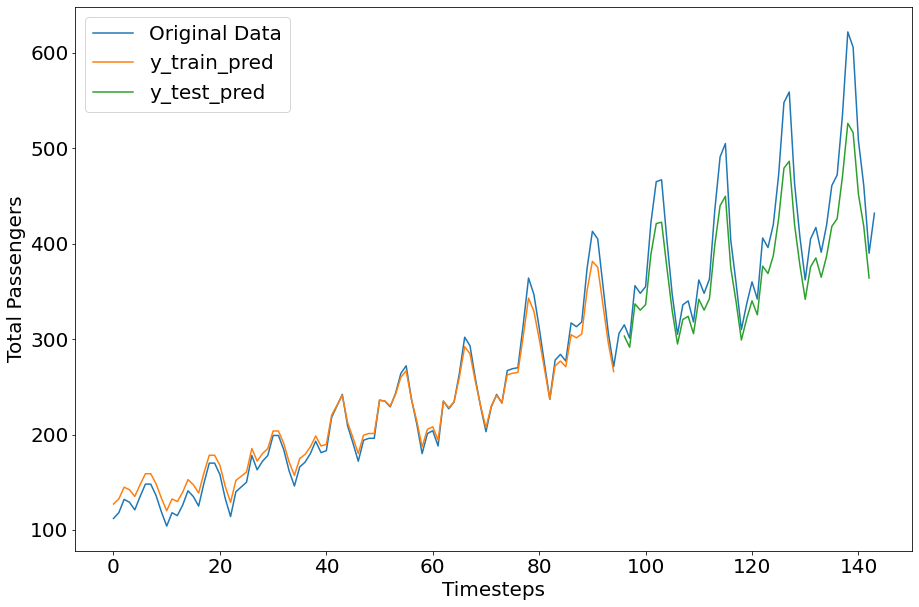

In [24]:
# Shift train predictions for plotting:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred  # Careful with this shifting!!!

# Shift test predictions for plotting:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = y_test_pred  # Careful with this shifting!!!

# Plot baseline and predictions:
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# TensorFlow **LSTM** for TimeSeries Data

In [144]:
def run_rnn_pipeline(
    state_size,
    n_epochs,
    n_timesteps,      # number of time steps
    n_x_vars,         # number of x variables
    n_y_vars,         # number of y variables
    learning_rate,
    cell_class,       # Vary this to play around with different RNN types.
    optimizer_class,
    # --------------
    X_train,
    Y_train,
    X_test,
    Y_test,
):
    
    # ====================================================================================================
    # Constants.
    print("-" * 20)
    print("state_size:", state_size)
    print("-" * 20)
    print("n_timesteps:", n_timesteps)
    print("n_x_vars:", n_x_vars)
    print("n_y_vars:", n_y_vars)
    print("-" * 20)
    
    # ====================================================================================================
    # Reset TF.
    tf.reset_default_graph()
    
    # ====================================================================================================
    # Placeholders
    X_placeholder = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='X_placeholder') 
    Y_placeholder = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='Y_placeholder')
    print("X_placeholder:", X_placeholder)
    print("Y_placeholder:", Y_placeholder)
    print("-" * 80)
    
    # ====================================================================================================
    # Unstack to make list: INPUTs
    rnn_inputs = tf.unstack(X_placeholder, axis=1)
    print("len(rnn_inputs):", len(rnn_inputs))
    print("rnn_inputs[0].shape", rnn_inputs[0].shape)
    print("-" * 80)
    
    # ====================================================================================================
    # [🧠] Define cell.
    cell = cell_class(state_size)
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # The key, if making RNNs directly with TF like this,
    # is to understand the helper functions, like static_rnn
    # and how their output is generated.
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    rnn_outputs, final_state = tf.nn.static_rnn(
        cell,              # The basic RNN cell object that we defined earlier. It could be another kind of cell, as we will see further in the chapter.
        rnn_inputs,        # The **list of Tensors** of shape (batch_size, number_of_inputs)
        dtype=tf.float32   # The data type of initial state and expected outputs.
    )
    print(f">>> Defined cell of type: {cell_class}")
    print("-" * 80)
    
    # ====================================================================================================
    # Here, use the convenience function `get_variable()` to define the variables for W and b.
    # NOTE: This Wx+b is in essence why the TFLearn net that you apply is a called "regression".
    W = tf.get_variable('W', [state_size, n_y_vars])
    b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))
    print("W", W)
    print("b", b)
    
    # ====================================================================================================
    # Compute predictions of our regression problem (well, rather, define the computational graph for).
    predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
    print("len(predictions):", len(predictions))
    print("predictions[0].shape", predictions[0].shape)
    
    # ====================================================================================================
    # Unstack to make list: OUTPUTs
    y_as_list = tf.unstack(Y_placeholder, num=n_timesteps, axis=1)
    print("len(y_as_list):", len(y_as_list))
    print("y_as_list[0].shape", y_as_list[0].shape)
    print("-" * 80)
    
    # ====================================================================================================
    # Define the loss function as mean squared error between the predicted and actual labels:
    mse = tf.losses.mean_squared_error
    losses = [
        mse(labels=label, predictions=prediction) 
        for prediction, label 
        in zip(predictions, y_as_list)
    ]
    total_loss = tf.reduce_mean(losses)
    print(f">>> Defined loss of type: {mse}")
    print("-" * 80)
    
    # ====================================================================================================
    # Define optimizer.
    optimizer = optimizer_class(learning_rate).minimize(total_loss)
    print(f">>> Defined optimizer of type: {optimizer_class}")
    print("-" * 80)
    
    # ====================================================================================================
    # >>> TRAIN! <<<
    with tf.Session() as tfs:
        tfs.run(tf.global_variables_initializer())

        # --- Training ---
        epoch_loss = 0.0
        for epoch in range(n_epochs):
            feed_dict={
                # Note the reshaping into appropriate shape:
                X_placeholder: X_train.reshape(-1, n_timesteps, n_x_vars), 
                Y_placeholder: Y_train.reshape(-1, n_timesteps, n_y_vars)
            }
            epoch_loss, y_train_pred, _ = tfs.run(
                [total_loss, predictions, optimizer],  # <-- Note what we're computing here. 
                feed_dict=feed_dict
            )
        print("train mse = {}".format(epoch_loss))

        # --- Evaluation ---
        feed_dict={
            X_placeholder: X_test.reshape(-1, n_timesteps, n_x_vars), 
            Y_placeholder: Y_test.reshape(-1, n_timesteps, n_y_vars)
        }
        test_loss, y_test_pred = tfs.run(
            [total_loss, predictions], 
            feed_dict=feed_dict
        )
    
    print('test mse = {}'.format(test_loss))
    print('test rmse = {}'.format(math.sqrt(test_loss)))
    
    # ====================================================================================================
    # These are returned as lists with one array item in them, so take them out of that list.
    # print(">>>>>>>>>>>>>>>>>>", len(y_train_pred))
    y_train_pred = y_train_pred[-1]
    y_test_pred = y_test_pred[-1]
    
    # ====================================================================================================
    # Inverse transform predictions
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)

    # Inverse transform originals
    y_train_orig = scaler.inverse_transform(Y_train)
    y_test_orig = scaler.inverse_transform(Y_test)
    
    # ====================================================================================================
    # Shift train predictions for plotting:
    print("y_train_pred.shape", y_train_pred.shape)
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[n_timesteps-1:len(y_train_pred)+n_timesteps-1, :] = y_train_pred  # Careful with this shifting!!!

    # Shift test predictions for plotting:
    print("y_test_pred.shape", y_test_pred.shape)
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[-len(y_test_pred)-n_timesteps:-n_timesteps, :] = y_test_pred  # Careful with this shifting!!!
    # OLD: len(y_train_pred)+(n_timesteps*2)-1:len(dataset)-1
    #  _testPredictPlot = np.empty_like(dataset)
    # _testPredictPlot[:, :] = np.nan
    # _testPredictPlot[len(y_train_pred)+(n_timesteps*2)-1:len(dataset)-1, :] = y_test_pred  # Careful with this shifting!!!
    
    # Plot baseline and predictions:
    plt.plot(dataset,label='Original Data')
    plt.plot(trainPredictPlot,label='y_train_pred')
    plt.plot(testPredictPlot,label='y_test_pred')
    # plt.plot(_testPredictPlot,label='_y_test_pred')
    plt.legend()
    plt.xlabel('Timesteps')
    plt.ylabel('Total Passengers')
    plt.show()


In [145]:
# Split into train and test sets:
train, test = dsu.train_test_split(normalized_dataset, train_size=0.67)  # Using a splitter from their helper datasetlib, as we're splitting over time.
# Convert into supervised learning set of input data and label
n_x = 1
n_y = 1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=n_y)

--------------------
state_size: 4
--------------------
n_timesteps: 1
n_x_vars: 1
n_y_vars: 1
--------------------
X_placeholder: Tensor("X_placeholder:0", shape=(?, 1, 1), dtype=float32)
Y_placeholder: Tensor("Y_placeholder:0", shape=(?, 1, 1), dtype=float32)
--------------------------------------------------------------------------------
len(rnn_inputs): 1
rnn_inputs[0].shape (?, 1)
--------------------------------------------------------------------------------
>>> Defined cell of type: <class 'tensorflow.python.ops.rnn_cell_impl.LSTMCell'>
--------------------------------------------------------------------------------
W <tf.Variable 'W:0' shape=(4, 1) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(1,) dtype=float32_ref>
len(predictions): 1
predictions[0].shape (?, 1)
len(y_as_list): 1
y_as_list[0].shape (?, 1)
--------------------------------------------------------------------------------
>>> Defined loss of type: <function mean_squared_error at 0x7ff182ed10e0>
-----------------

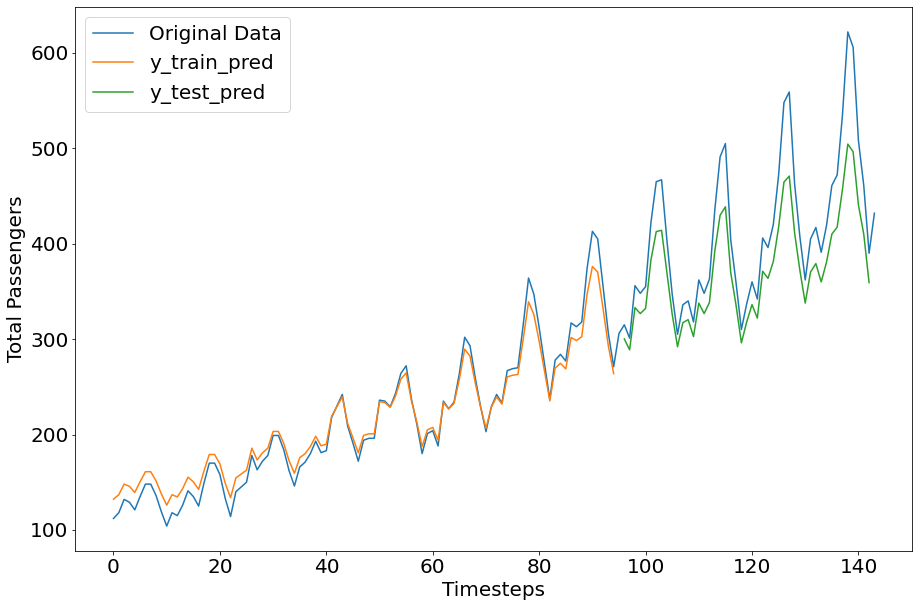

In [147]:
# Run pipeline for LSTM.

run_rnn_pipeline(
    state_size=4,
    n_epochs=600,
    n_timesteps=n_x,    # number of time steps
    n_x_vars=1,         # number of x variables
    n_y_vars=1,         # number of y variables
    learning_rate=0.1,
    cell_class=tf.nn.rnn_cell.LSTMCell,  # <-- NOTE: LSTM!
    optimizer_class=tf.train.AdagradOptimizer,
    # --------------
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
)

# TensorFlow **GRU** for TimeSeries Data

--------------------
state_size: 4
--------------------
n_timesteps: 1
n_x_vars: 1
n_y_vars: 1
--------------------
X_placeholder: Tensor("X_placeholder:0", shape=(?, 1, 1), dtype=float32)
Y_placeholder: Tensor("Y_placeholder:0", shape=(?, 1, 1), dtype=float32)
--------------------------------------------------------------------------------
len(rnn_inputs): 1
rnn_inputs[0].shape (?, 1)
--------------------------------------------------------------------------------
>>> Defined cell of type: <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>
--------------------------------------------------------------------------------
W <tf.Variable 'W:0' shape=(4, 1) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(1,) dtype=float32_ref>
len(predictions): 1
predictions[0].shape (?, 1)
len(y_as_list): 1
y_as_list[0].shape (?, 1)
--------------------------------------------------------------------------------
>>> Defined loss of type: <function mean_squared_error at 0x7ff182ed10e0>
------------------

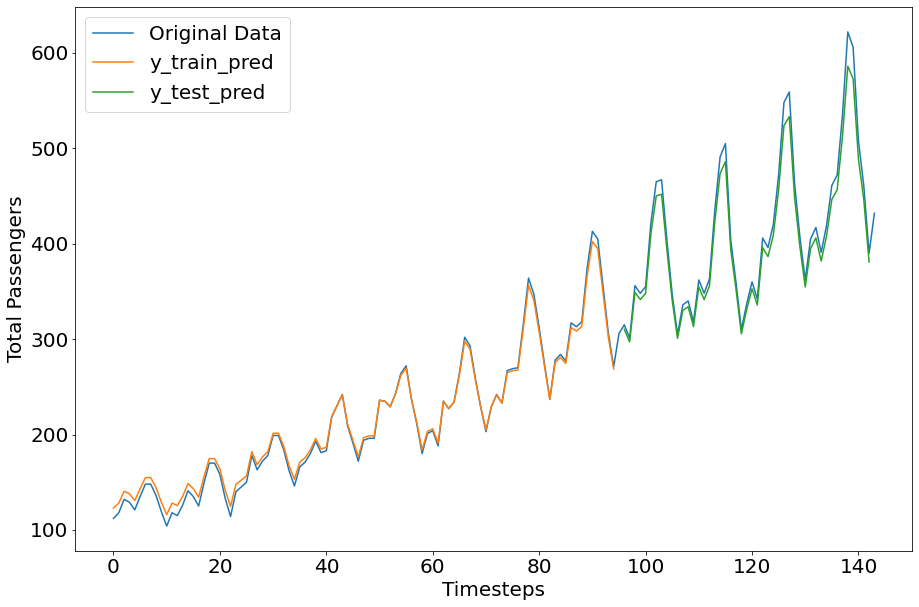

In [148]:
# Run pipeline for GRU.

run_rnn_pipeline(
    state_size=4,
    n_epochs=600,
    n_timesteps=n_x,    # number of time steps
    n_x_vars=1,         # number of x variables
    n_y_vars=1,         # number of y variables
    learning_rate=0.1,
    cell_class=tf.nn.rnn_cell.GRUCell,  # <-- NOTE: GRU!
    optimizer_class=tf.train.AdagradOptimizer,
    # --------------
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
)

# Try different window size

⚠️ This is a convoluted mess.

In [149]:
# Split into train and test sets:
train, test = dsu.train_test_split(normalized_dataset, train_size=0.67)  # Using a splitter from their helper datasetlib, as we're splitting over time.

# Convert into supervised learning set of input data and label
n_x = 3
n_y = 3
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=n_y)

In [150]:
print("X_train.shape:", X_train.shape)
print(X_train[0:5], "\n...")

print("Y_train.shape:", Y_train.shape)
print(Y_train[0:5], "\n...")

print("X_test.shape:", X_test.shape)
print(X_test[0:5], "\n...")

print("Y_test.shape:", Y_test.shape)
print(Y_test[0:5], "\n...")

X_train.shape: (91, 3)
[[0.01544401 0.02702703 0.05405405]
 [0.02702703 0.05405405 0.04826255]
 [0.05405405 0.04826255 0.03281853]
 [0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494207]] 
...
Y_train.shape: (91, 3)
[[0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494207]
 [0.05984557 0.08494207 0.08494207]
 [0.08494207 0.08494207 0.06177607]
 [0.08494207 0.06177607 0.02895753]] 
...
X_test.shape: (43, 3)
[[0.4073359  0.3803089  0.48648646]
 [0.3803089  0.48648646 0.47104248]
 [0.48648646 0.47104248 0.484556  ]
 [0.47104248 0.484556   0.6138996 ]
 [0.484556   0.6138996  0.6969112 ]] 
...
Y_test.shape: (43, 3)
[[0.47104248 0.484556   0.6138996 ]
 [0.484556   0.6138996  0.6969112 ]
 [0.6138996  0.6969112  0.70077217]
 [0.6969112  0.70077217 0.57915056]
 [0.70077217 0.57915056 0.46911195]] 
...


--------------------
state_size: 4
--------------------
n_timesteps: 3
n_x_vars: 1
n_y_vars: 1
--------------------
X_placeholder: Tensor("X_placeholder:0", shape=(?, 3, 1), dtype=float32)
Y_placeholder: Tensor("Y_placeholder:0", shape=(?, 3, 1), dtype=float32)
--------------------------------------------------------------------------------
len(rnn_inputs): 3
rnn_inputs[0].shape (?, 1)
--------------------------------------------------------------------------------
>>> Defined cell of type: <class 'tensorflow.python.ops.rnn_cell_impl.GRUCell'>
--------------------------------------------------------------------------------
W <tf.Variable 'W:0' shape=(4, 1) dtype=float32_ref>
b <tf.Variable 'b:0' shape=(1,) dtype=float32_ref>
len(predictions): 3
predictions[0].shape (?, 1)
len(y_as_list): 3
y_as_list[0].shape (?, 1)
--------------------------------------------------------------------------------
>>> Defined loss of type: <function mean_squared_error at 0x7ff182ed10e0>
------------------

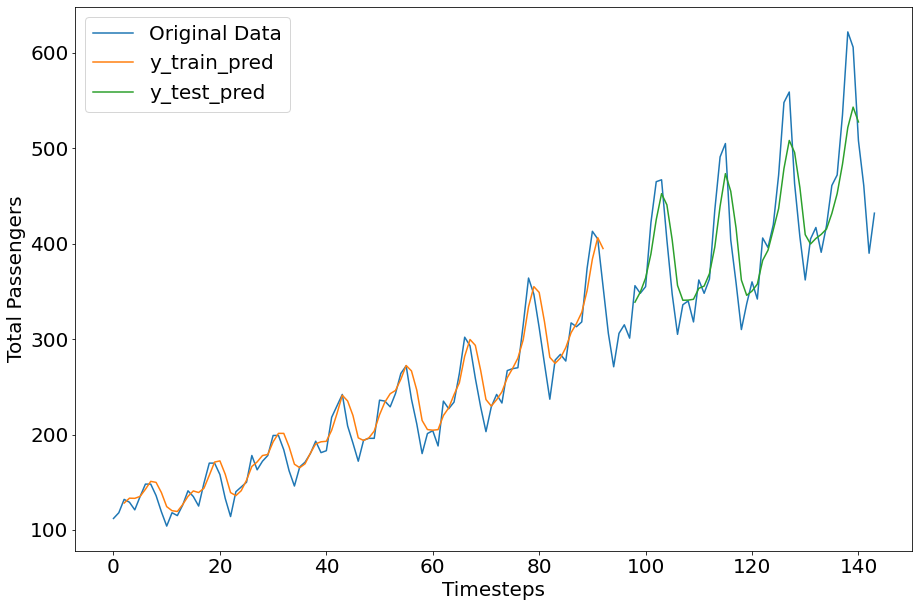

In [151]:
run_rnn_pipeline(
    state_size=4,
    n_epochs=600,
    n_timesteps=n_x,    # [⚠️] number of time steps.
    n_x_vars=1,         # number of x variables
    n_y_vars=1,         # number of y variables
    learning_rate=0.1,
    cell_class=tf.nn.rnn_cell.GRUCell,  # <-- NOTE: GRU!
    optimizer_class=tf.train.AdagradOptimizer,
    # --------------
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
)